<a href="https://colab.research.google.com/github/Abhilaksh1498/SoC-20-Chatbot/blob/master/Transfer_Learning_Rock_Paper_Scissors_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# We'll use Rock-Paper-Dataset (because pre-trained Inception model can only be used with coloured images)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-06-15 18:55:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   152MB/s    in 1.3s    

2020-06-15 18:55:51 (152 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2020-06-15 18:55:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/t

In [0]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [5]:
print('total training rock images:', len(os.listdir('/content/rps/rock')))
print('total training paper images:', len(os.listdir('/content/rps/paper')))
print('total training scissors images:', len(os.listdir('/content/rps/scissors')))

total training rock images: 840
total training paper images: 840
total training scissors images: 840


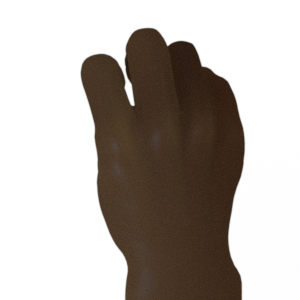

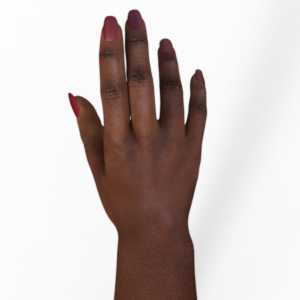

In [6]:
# Display some images
from IPython.display import Image, display
display(Image('/content/rps/rock/'+os.listdir('/content/rps/rock')[10], width = 200, height =200))
display(Image('/content/rps/paper/' + os.listdir('/content/rps/paper')[10], width = 200, height =200))

In [7]:
# Creating generators for training and validation data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale= 1.0/255., 
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
training_data = train_generator.flow_from_directory(directory= '/content/rps/', target_size= (150,150),
                                                    class_mode= 'categorical', batch_size= 50, )

validation_generator = ImageDataGenerator(rescale= 1.0/255. )
validation_data = validation_generator.flow_from_directory(directory= '/content/rps-test-set/', target_size= (150,150), 
                                                           class_mode= 'categorical', batch_size= 50)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [0]:
# We'll use Inception V3 model that can be directly loaded from tensorflow 
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(input_shape= (150,150,3), include_top= False, weights= 'imagenet')  # returns a keras.model instance
# include_top = False => we are not using Dense layer at the last (which had 1000 units relevant to original dataset)
base_model.summary()

##Feature Extraction##

In [15]:
# We'll not train the convolution weights
# Add the FC and final Dense layer with activation function relevant for our own dataset
from tensorflow.keras import layers
from tensorflow.keras import Model
for layer in base_model.layers:
  layer.trainable = False

last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( base_model.input, x)

In [0]:
model.summary() 
# Initially parameters summary is 
# Total params: 47,514,531
# Trainable params: 38,539,267    (This is precisely equal to trainable parameters for last 2 Dense layers we added)
# Non-trainable params: 8,975,264

 In most convolutional networks, the higher up a layer is (i.e. layers appearing download in model.summary() like FC layers), the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'] )
history = model.fit(training_data,
                    validation_data=validation_data, # validation_split argument isn't supported when working with generators
                    # By default steps_per_epoch parameter is num_samples/batch size
                    epochs=2)
                    # validation_steps also need not be provided, it is total no of times validation_batch_size (specified in generator class)
                    # num of samples will be tested for validation after each epoch

Epoch 1/2
51/51 [==============================] - 24s 476ms/step - loss: 1.3855 - accuracy: 0.8290 - val_loss: 0.2679 - val_accuracy: 0.9140
Epoch 2/2
51/51 [==============================] - 23s 447ms/step - loss: 0.1108 - accuracy: 0.9623 - val_loss: 0.0485 - val_accuracy: 0.9839


##Fine Tuning##
In the feature extraction, weights of the pre-trained network were not updated during training. Here we also train some of the bottom convolutional layers to be trainable as well (alongside our FC layers)

The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning

In [17]:
# to do finetuning unfreeze the base_model and set the bottom layers to be un-trainable. 
# Recompile the model (necessary for these changes to take effect), and resume training

# Let's take a look to see how many layers are in the model 
print("Number of layers in the model: ", len(model.layers))
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the model:  233


*We dont need to instantiate model again using Model() after updating training status of base model*

In [0]:
model.summary()
# Now we can see the change in parameter stats
# Total params: 47,514,531
# Trainable params: 40,531,651    (this also includes some weights in convolutional layers of model)
# Non-trainable params: 6,982,880

In [19]:
# Compile the model using a much lower learning rate.
# note that the training is continued further
model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate= .001/10), metrics= ['accuracy'] )
history = model.fit(training_data,
                    validation_data=validation_data, # validation_split argument isn't supported when working with generators
                    # By default steps_per_epoch parameter is num_samples/batch size
                    epochs=10)
                    # validation_steps also need not be provided, it is total no of times validation_batch_size (specified in generator class)
                    # num of samples will be tested for validation after each epoch

Epoch 1/10
51/51 [==============================] - 24s 475ms/step - loss: 0.0674 - accuracy: 0.9790 - val_loss: 0.1825 - val_accuracy: 0.9624
Epoch 2/10
51/51 [==============================] - 23s 457ms/step - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.2404 - val_accuracy: 0.9220
Epoch 3/10
51/51 [==============================] - 23s 456ms/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.0782 - val_accuracy: 0.9785
Epoch 4/10
51/51 [==============================] - 23s 455ms/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.0805 - val_accuracy: 0.9758
Epoch 5/10
51/51 [==============================] - 23s 455ms/step - loss: 0.0101 - accuracy: 0.9956 - val_loss: 0.0542 - val_accuracy: 0.9812
Epoch 6/10
51/51 [==============================] - 23s 458ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0756 - val_accuracy: 0.9812
Epoch 7/10
51/51 [==============================] - 23s 455ms/step - loss: 0.0095 - accuracy: 0.9960 - val_loss: 0.0996 - val_accuracy: 0.9624

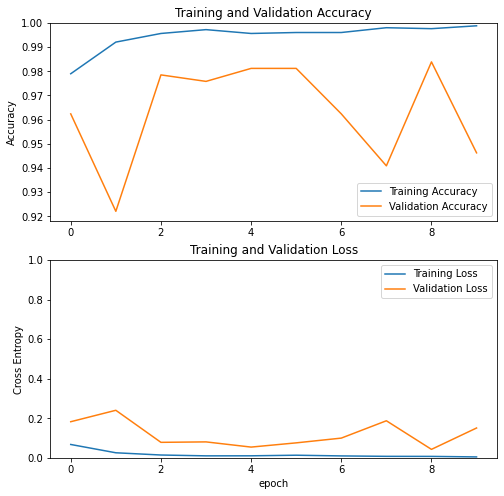

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()